In [7]:
import pandas as pd

df = pd.read_csv("sales.csv",index_col=0)
df.head(5)


,customer_id,category,quantity,invoice_date,Selling_price_per_quantity,cost_price_per_quantity,shopping_mall,Total_cost_price,Total_selling_price,Total_profit_earned
invoice_no,,,,,,,,,,
I138884,C241288,Clothing,5,05-08-2022,1500.40,1200.32,South Coast Plaza,6001.60,7502.00,1500.40
I317333,C111565,Shoes,3,12-12-2021,1800.51,1374.44,Beverly Center,4123.31,5401.53,1278.22
I127801,C266599,Clothing,1,09-11-2021,300.08,243.97,Westfield Century City,243.97,300.08,56.11
I173702,C988172,Shoes,5,05/16/2021,3000.85,2158.88,Stanford Shopping Center,10794.42,15004.25,4209.83
I337046,C189076,Books,4,10/24/2021,60.60,42.38,South Coast Plaza,169.51,242.40,72.89


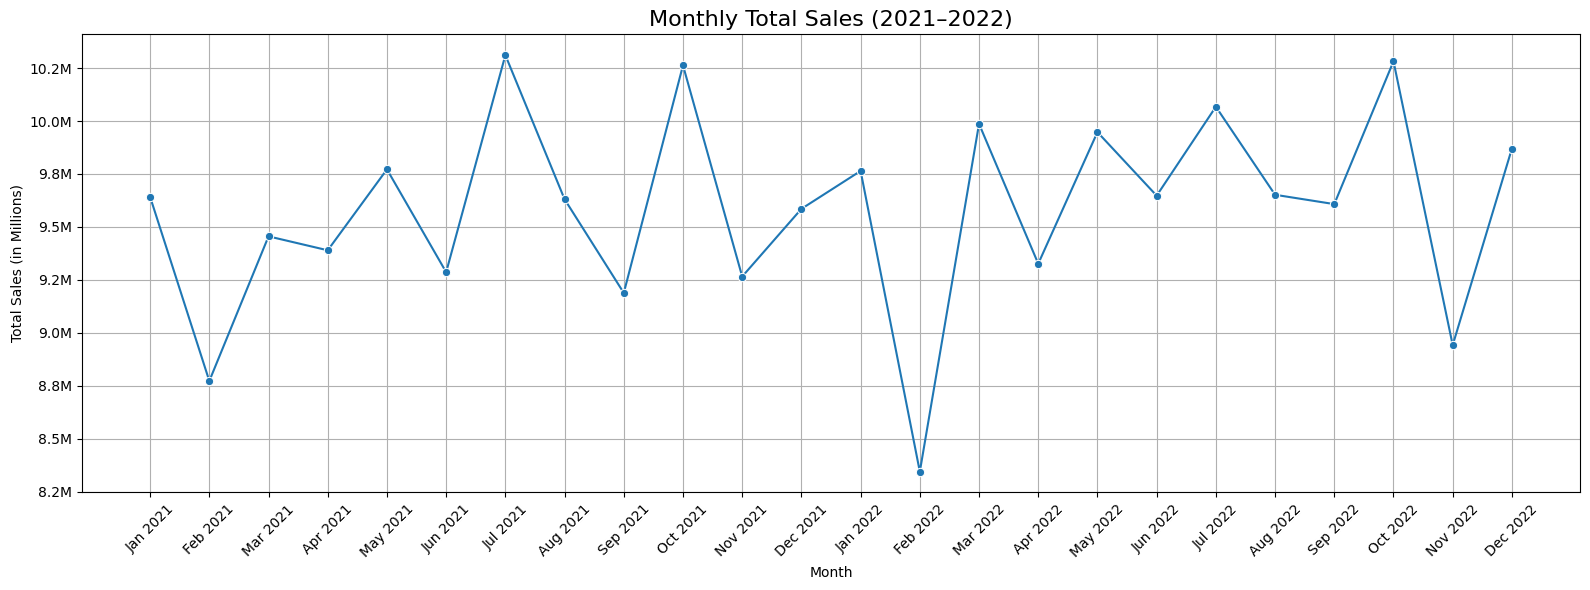

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Convert date column with auto format detection
df['invoice_date'] = pd.to_datetime(df['invoice_date'], format='mixed', dayfirst=True, errors='coerce')

# Filter data for 2021 and 2022
df = df[(df['invoice_date'].dt.year >= 2021) & (df['invoice_date'].dt.year <= 2022)]

# Set date as index and sort
df.set_index('invoice_date', inplace=True)
df.sort_index(inplace=True)

# Aggregate by month
monthly_sales = df['Total_selling_price'].resample('M').sum()

# Format x-axis labels as "Jan 2021", "Feb 2021", ...
monthly_sales.index = monthly_sales.index.strftime('%b %Y')

# Plot
plt.figure(figsize=(16, 6))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker='o')
plt.title('Monthly Total Sales (2021–2022)', fontsize=16)
plt.ylabel('Total Sales (in Millions)')
plt.xlabel('Month')
plt.xticks(rotation=45)

# Format y-axis in Millions (e.g., 0.5M, 1M)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

plt.grid(True)
plt.tight_layout()
plt.show()


 1. Trend
The overall trend is fairly stable across the two years.

There are no strong upward or downward movements in sales.

However, slight improvement in mid-2022 could indicate modest growth.

2. Seasonality
Regular peaks in:

July (both 2021 and 2022)

October (major spike in both years)

Consistent dips in:

February (lowest in both years)

November 2022 also dips sharply — might be an outlier or special case.

This repeating pattern every year confirms seasonality in your sales.

3. Volatility
Monthly values fluctuate within a narrow band (8.3M to 10.2M) — this is predictable and model-friendly.

No random erratic behavior (i.e., no strong outliers).

 4. Anomalies
Feb 2022 has a sharp dip compared to other months — double-check if data is complete or if it’s a genuine seasonal event (e.g., short month, off-season).


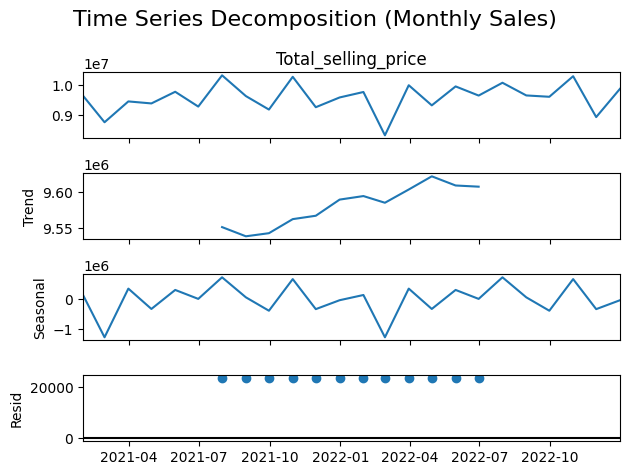

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Use the original monthly_sales series before it was formatted
monthly_sales = df['Total_selling_price'].resample('M').sum()

# Decompose the series
decomposition = seasonal_decompose(monthly_sales, model='additive')

# Plot the decomposition
decomposition.plot()
plt.suptitle('Time Series Decomposition (Monthly Sales)', fontsize=16)
plt.tight_layout()
plt.show()


1️⃣ Observed (Top Panel)
This is the original monthly sales.

Shows cyclical up-and-down patterns → aligns with what we saw in the line plot earlier.

2️⃣ Trend
The trend is gradually increasing between early 2021 and mid-2022.

Slight flattening in late 2022.

Implication: The business is growing slowly, so forecasting should capture this upward trend.

3️⃣ Seasonality
Clear repeating wave pattern every ~12 months.

Indicates strong seasonality (e.g., spikes in July/October, dips in Feb/Nov).

This means we must use a model that supports seasonality.

4️⃣ Residual
Mostly small, centered around zero.

This is good: it means most of the signal is captured by the trend + seasonal components.

No large unexplained spikes → your data is predictable and modelable.

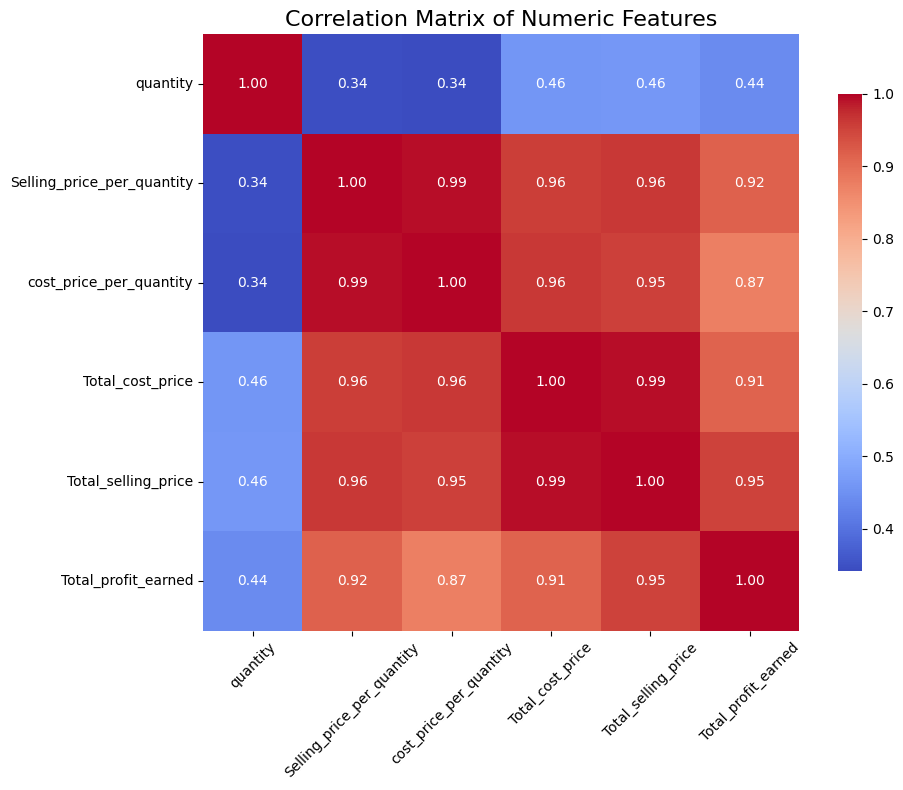

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numeric Features', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


A correlation matrix was generated to understand the linear relationships between key numerical variables such as quantity, unit prices, total cost, total sales, and profit. The analysis revealed a very strong positive correlation between Total_selling_price and Total_cost_price (r = 0.99), indicating that as total sales increase, total costs rise proportionally. Additionally, Total_profit_earned shows a high correlation with Total_selling_price (r = 0.95), suggesting that revenue plays a significant role in determining profit. Interestingly, both Selling_price_per_quantity and cost_price_per_quantity are almost perfectly correlated (r = 0.99), implying a consistent pricing strategy or markup pattern. On the other hand, quantity shows only a moderate correlation (~0.44–0.46) with revenue and profit, indicating that while sales volume contributes to financial outcomes, unit pricing has a more substantial impact. These insights can help shape business strategies related to pricing, cost management, and sales planning.


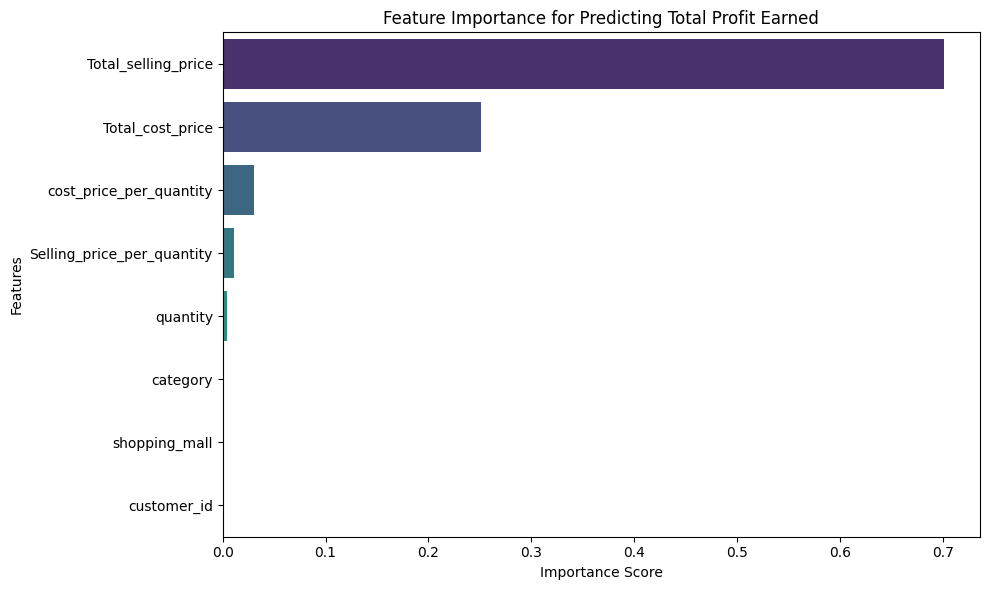

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# # Load your cleaned dataset
# df = pd.read_csv('final_sales_data.csv')

# # Drop rows with missing values (optional)
# df.dropna(inplace=True)

# Encode categorical variables
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define X (features) and y (target)
X = df.drop('Total_profit_earned', axis=1)
y = df['Total_profit_earned']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title("Feature Importance for Predicting Total Profit Earned")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


The feature importance plot illustrates the relative impact of each variable on predicting the Total_profit_earned. It clearly shows that Total_selling_price is the most significant contributor, followed by Total_cost_price, while other features like cost_price_per_quantity, Selling_price_per_quantity, and quantity have minimal influence. Non-numerical or identifier features such as invoice_no, shopping_mall, and customer_id contribute negligibly. This analysis confirms that profit is primarily driven by sales and cost metrics, helping to focus the model on the most relevant variables.

--------------------------------

time series forcasting


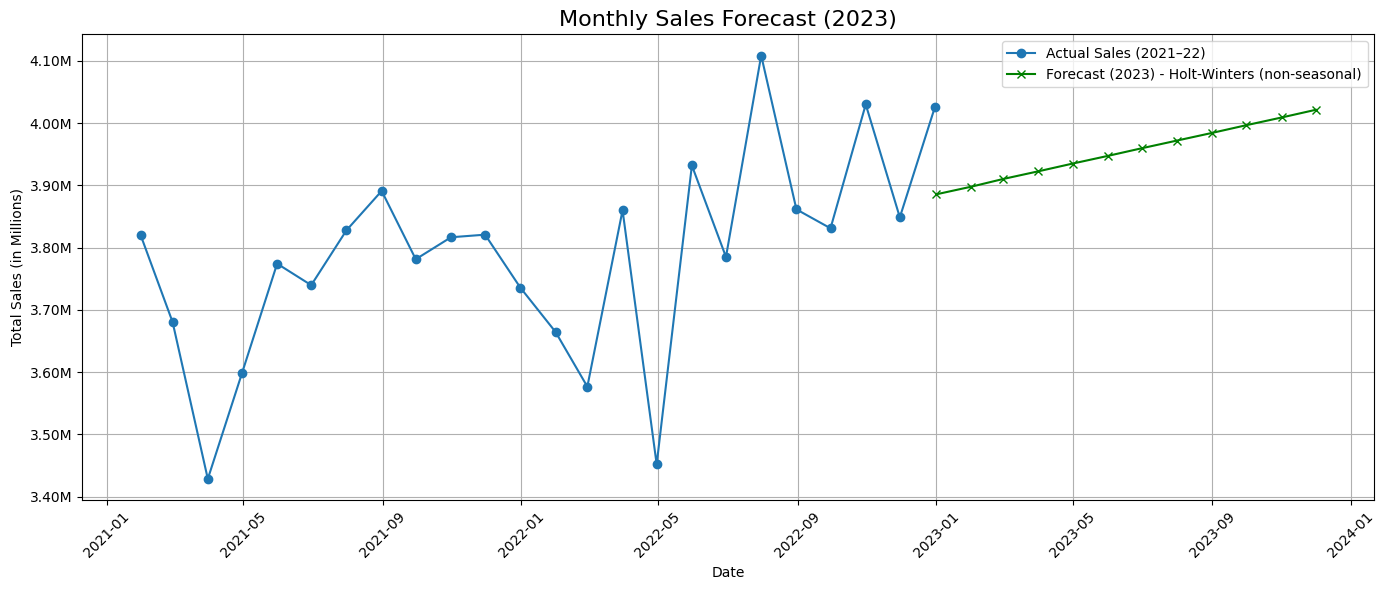


 Best Model: Holt-Winters (non-seasonal)

 Forecasted Monthly Sales for 2023:
        Month Predicted_Total_Sales
0  2023-01-01                 3.89M
1  2023-02-01                 3.90M
2  2023-03-01                 3.91M
3  2023-04-01                 3.92M
4  2023-05-01                 3.93M
5  2023-06-01                 3.95M
6  2023-07-01                 3.96M
7  2023-08-01                 3.97M
8  2023-09-01                 3.98M
9  2023-10-01                 4.00M
10 2023-11-01                 4.01M
11 2023-12-01                 4.02M


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.ticker as ticker
import warnings

warnings.filterwarnings("ignore")

# Load and preprocess data
df = pd.read_csv("sales.csv")
df['invoice_date'] = pd.to_datetime(df['invoice_date'], errors='coerce', dayfirst=True)
df.dropna(subset=['invoice_date'], inplace=True)

df = df[(df['invoice_date'].dt.year >= 2021) & (df['invoice_date'].dt.year <= 2022)]
df.set_index('invoice_date', inplace=True)
df.sort_index(inplace=True)

monthly_sales = df['Total_selling_price'].resample('M').sum()

# Train/test split
train = monthly_sales[:-3]
test = monthly_sales[-3:]

# ARIMA
arima_model = ARIMA(train, order=(1, 1, 1)).fit()
arima_pred = arima_model.forecast(steps=3)
arima_rmse = np.sqrt(mean_squared_error(test, arima_pred))

# Holt-Winters (non-seasonal)
hw_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit()
hw_pred = hw_model.forecast(3)
hw_rmse = np.sqrt(mean_squared_error(test, hw_pred))

# Best model selection
if arima_rmse < hw_rmse:
    best_model = arima_model
    best_model_name = "ARIMA"
else:
    best_model = hw_model
    best_model_name = "Holt-Winters (non-seasonal)"

# Forecast 2023
forecast_2023 = best_model.forecast(12)
forecast_2023.index = pd.date_range(start='2023-01-01', periods=12, freq='MS')

# Plot
plt.figure(figsize=(14, 6))
plt.plot(monthly_sales.index, monthly_sales.values / 1e6, label='Actual Sales (2021–22)', marker='o')
plt.plot(forecast_2023.index, forecast_2023.values / 1e6, label=f'Forecast (2023) - {best_model_name}', marker='x', color='green')
plt.title("Monthly Sales Forecast (2023)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Total Sales (in Millions)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}M'))
plt.tight_layout()
plt.show()

# Print forecast table with values in Millions
forecast_df = forecast_2023.reset_index()
forecast_df.columns = ['Month', 'Predicted_Total_Sales']
forecast_df['Predicted_Total_Sales'] = forecast_df['Predicted_Total_Sales'].apply(lambda x: f'{x/1e6:.2f}M')

print(f"\n Best Model: {best_model_name}")
print("\n Forecasted Monthly Sales for 2023:")
print(forecast_df)
